# 0. Import Dependencies

In [1]:
!pip install vncorenlp --quiet
!pip install py_vncorenlp --quiet
!pip install dvc --quiet
# !pip install imblearn
# !pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 10.6 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645951 sha256=aa0b84cd9c7b008979ac9e9970b0af5bf5604569622308752cd755304d111b25
  Stored in directory: /root/.cache/pip/wheels/5d/d9/b3/41f6c6b1ab758561fd4aab55dc0480b9d7a131c6aaa573a3fa
Successfully built vncorenlp
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.2 MB/s eta 0:00:0000:010:01
  Created wheel for py_vncorenlp: filename=py_vncorenlp-0.1.4-py3-none-any.whl size=4324 sha256=ab1a8c20d74d4b3a2fc7a41186b4c3f80c86844b5db4ade4a1a5459cbe610569
  Stored in directory: /root/.cache/pip/wheels/d5/d9/bf/62632cdb007c702a0664091e92a0bb1f18a2fcecbe962d9827
Successfully built py_vncorenlp


In [2]:
from vncorenlp import VnCoreNLP

In [3]:
import py_vncorenlp
py_vncorenlp.download_model()

VnCoreNLP model folder . already exists! Please load VnCoreNLP from this folder!


In [4]:
import os
import json
import string
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow import keras
from tensorflow import Tensor
from tensorflow.keras import backend as K


from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, Dropout, Bidirectional, LSTM, TimeDistributed
from tensorflow_addons.text import crf_log_likelihood
from tensorflow_addons.layers import CRF

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight as sklearn_class_weight
from transformers import PhobertTokenizer, TFAutoModel
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# 1. Load Models

In [ ]:
# Load data from dagshub storage

!dvc get https://dagshub.com/nnngoc/bkchatbot intent-data

In [5]:
INTENT_LIST = [
    'policy',
    'answer',
    'greeting',
    'confirm',
    'disagree',
    'chitchat',
    'thanks',
]
# DATA_PATH = '/kaggle/input/intent-data/intent_data_09062023.csv'
DATA_PATH = '/kaggle/working/intent-data/intent_data_09062023.csv'
RESAMPLING_STRATEGY = {
    1: 500,
    2: 500,
    3: 500,
    4: 500,
    5: 500,
    6: 500,
}
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.1
BATCH_SIZE = 32

In [6]:
annotator = VnCoreNLP("VnCoreNLP-1.2.jar", annotators="wseg", max_heap_size='-Xmx500m')
tokenizer = PhobertTokenizer.from_pretrained("vinai/phobert-base")
# resampler = RandomOverSampler(sampling_strategy=sampling_strategy,random_state=0)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
langauge_model = TFAutoModel.from_pretrained("vinai/phobert-base").roberta
pooling = GlobalAveragePooling1D()

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


# 2. Data Processing

In [8]:
class Data_Processor:
    def __init__(self, annotator, tokenizer):
        self.annotator = annotator
        self.tokenizer = tokenizer
    
    def batch_annonate(self, text):
        def annotate(annotator):
            def apply(x):
                return ' '.join([' '.join(text) for text in annotator.tokenize(x)])
            return apply
        return list(map(annotate(self.annotator), text))
    
    def batch_tokenize(self, batch_input):
        tokenized_text = self.tokenizer(batch_input, padding ='max_length',return_tensors = 'np', truncation=True)
        return tokenized_text
    
    def batch_clean(self, batch_input):
        def clean_text(text):
            text = text.lower()
            text = "".join([i for i in text if i not in string.punctuation])
            return text
        return list(map(clean_text, batch_input))
    
    def data_processing(self, batch_input):
        # batch_input = self.batch_clean(batch_input)
        batch_input = self.batch_annonate(batch_input)
        batch_input = self.batch_tokenize(batch_input)
        return batch_input

In [9]:
class Intent_Data_Loader:
    def __init__(self, intent_list, data_path, annotator, tokenizer, langauge_model, pooling):
        self.intent_list = intent_list
        self.data_path = data_path
        self.intent2id, self.id2intent = self.create_intent_dict(intent_list)
        
        self.data_processor = Data_Processor(annotator, tokenizer)
        self.resampler = SMOTE(random_state=0)
        
        self.langauge_model = langauge_model
        self.pooling = pooling

        # add new
        # self.data = self.data.numpy()
    
    def create_intent_dict(self, intent_list):
        return {i: intent_list.index(i) for i in intent_list}, {intent_list.index(i)+1: i for i in intent_list}
    
    def load_data(self):
        # load csv files from data folder
        df = pd.read_csv(self.data_path)
        self.text = df['Utterance']
        self.label = df['Intent']
    
    def create_data(self):
        # load_raw_text
        self.load_data()
        
        self.label = [self.intent2id[label] for label in self.label]
        self.label = self.create_categorical_label()
        
        self.text = np.array(self.text)
        self.index = np.array([i for i in range(len(self.text))])
        
        # self.resample_index, self.resample_label = self.resampler.fit_resample(self.index, self.label)
        # self.resample_text = np.take(self.text, self.resample_index.ravel())
        
        self.text = self.data_processor.data_processing(self.text)
        self.input_ids = self.text['input_ids']
        self.attention_mask = self.text['attention_mask']
        
    def create_class_weight(self):
        # create class weight
        class_weight_vec = sklearn_class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(self.resample_intent),
            y=self.resample_intent,
        )
        self.class_weight = {i: class_weight_vec[i] for i in range(len(np.unique(self.resample_intent)))}
        
    def create_categorical_label(self):
        return keras.utils.to_categorical(self.label)
        
    def emed_text(self, batch_size=128):
        dataset_length = self.input_ids.shape[0]
        number_of_batch = dataset_length // batch_size
        for i in tqdm(range(number_of_batch)):
            index = self.index[i * batch_size : (i + 1) * batch_size]
            input_ids = self.input_ids[index]
            attention_mask = self.attention_mask[index]
            
            word_embedding = self.langauge_model(input_ids = input_ids, attention_mask = attention_mask)[0]
            data = self.pooling(word_embedding)
            
            if i == 0:
                self.data= data
            else:
                self.data=tf.concat([self.data, data], 0)
        
        if number_of_batch*batch_size < dataset_length:
            index = self.index[number_of_batch * batch_size:]
            input_ids = self.input_ids[index]
            attention_mask = self.attention_mask[index]
            
            word_embedding = self.langauge_model(input_ids = input_ids, attention_mask = attention_mask)[0]
            data = self.pooling(word_embedding)
            
            self.data=tf.concat([self.data, data], 0)
        
        self.data = self.data.numpy()

In [10]:
tag = 'cased_smote_with_faq'

In [11]:
# %%time
data_loader = Intent_Data_Loader(INTENT_LIST, DATA_PATH, annotator, tokenizer, langauge_model, pooling)
data_loader.create_data()
data_loader.emed_text()

100%|██████████| 37/37 [00:41<00:00,  1.13s/it]


CPU times: user 20.5 s, sys: 1.78 s, total: 22.3 s
Wall time: 58.9 s


In [12]:
# np.save(f'intent_input_ids_{tag}.npy'.format(tag), data_loader.resample_text['input_ids'])
# np.save(f'intent_attention_mask_{tag}.npy'.format(tag), data_loader.resample_text['attention_mask'])
np.save(f'intent_data_{tag}.npy'.format(tag), data_loader.data)
np.save(f'intent_label_{tag}.npy'.format(tag), data_loader.label)

In [13]:
# ]input_ids = np.load(f'intent_input_ids_{tag}.npy'.format(tag))
# attention_mask = np.load(f'intent_attention_mask_{tag}.npy'.format(tag))
data = np.load(f'intent_data_{tag}.npy'.format(tag))
label = np.load(f'intent_label_{tag}.npy'.format(tag))

In [14]:
resampler = SMOTE(random_state=0)
data, label = resampler.fit_resample(data, label)

In [15]:
# index = np.array([i for i in range(input_ids.shape[0])])

In [16]:
train_data, test_data, train_label, test_label = train_test_split(data, label, test_size=TEST_SIZE)
train_data, validation_data, train_label, validation_label = train_test_split(train_data, train_label, test_size=VALIDATION_SIZE)

In [17]:
train_data = tf.convert_to_tensor(train_data)
validation_data = tf.convert_to_tensor(validation_data)
test_data = tf.convert_to_tensor(test_data)

train_label = tf.convert_to_tensor(train_label)
validation_label = tf.convert_to_tensor(validation_label)
test_label = tf.convert_to_tensor(test_label)

intent_train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_label)).batch(BATCH_SIZE)
intent_validation_dataset = tf.data.Dataset.from_tensor_slices((validation_data, validation_label)).batch(BATCH_SIZE)
intent_test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_label)).batch(BATCH_SIZE)

intent_train_dataset.cache()
intent_validation_dataset.cache()
intent_test_dataset.cache()

intent_train_dataset.prefetch(tf.data.AUTOTUNE)
intent_validation_dataset.prefetch(tf.data.AUTOTUNE)
intent_test_dataset.prefetch(tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 768), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.int64, name=None))>

# 3. Model Training

In [18]:
inputs = Input(shape=(768,), dtype = 'float32')
dropout = Dropout(0.1)(inputs)
dense = Dense(
        units=7,
        activation='softmax',
        kernel_regularizer=tf.keras.regularizers.L2(0.00001),
        bias_regularizer=tf.keras.regularizers.L2(0.00001),
        activity_regularizer=tf.keras.regularizers.L2(0.00001),
)(dropout)
model = Model(inputs, dense)

In [19]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = [
        keras.metrics.CategoricalAccuracy(name='acc'),
        tf.keras.metrics.Precision(name='prec'),
        tf.keras.metrics.Recall(name='rec'),
        tfa.metrics.F1Score(7, name='f1', average='macro')
    ]

In [20]:
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics,
)

In [21]:
history = model.fit(
    x=intent_train_dataset,
    epochs=100,
    validation_data=intent_validation_dataset,
)

Epoch 1/100
722/722 [==============================] - 6s 5ms/step - loss: 0.2550 - acc: 0.9555 - prec: 0.9948 - rec: 0.8927 - f1: 0.9555 - val_loss: 0.0507 - val_acc: 0.9949 - val_prec: 0.9969 - val_rec: 0.9942 - val_f1: 0.9950
Epoch 2/100
722/722 [==============================] - 3s 4ms/step - loss: 0.0343 - acc: 0.9971 - prec: 0.9979 - rec: 0.9962 - f1: 0.9971 - val_loss: 0.0224 - val_acc: 0.9973 - val_prec: 0.9980 - val_rec: 0.9969 - val_f1: 0.9973
Epoch 3/100
722/722 [==============================] - 3s 4ms/step - loss: 0.0181 - acc: 0.9984 - prec: 0.9988 - rec: 0.9980 - f1: 0.9984 - val_loss: 0.0143 - val_acc: 0.9981 - val_prec: 0.9984 - val_rec: 0.9977 - val_f1: 0.9981
Epoch 4/100
722/722 [==============================] - 3s 4ms/step - loss: 0.0119 - acc: 0.9988 - prec: 0.9991 - rec: 0.9987 - f1: 0.9988 - val_loss: 0.0105 - val_acc: 0.9988 - val_prec: 0.9992 - val_rec: 0.9984 - val_f1: 0.9989
Epoch 5/100
722/722 [==============================] - 3s 4ms/step - loss: 0.0090 - 

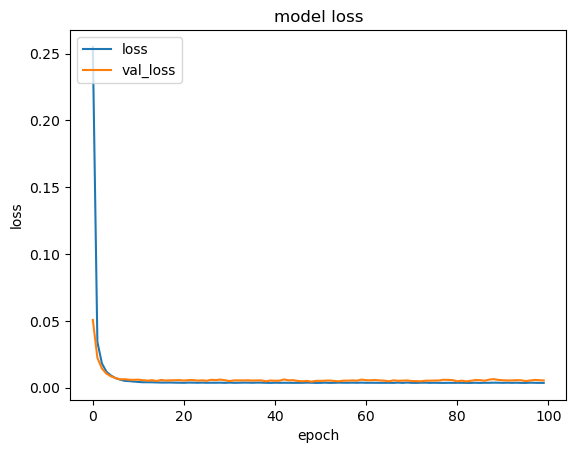

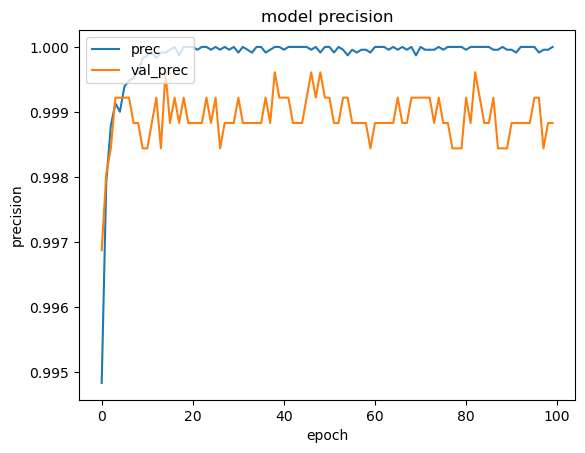

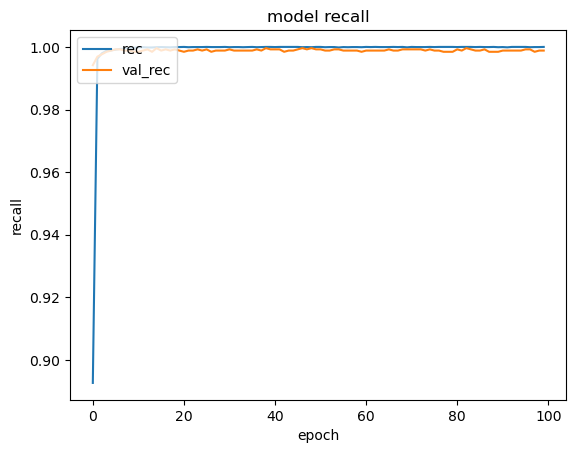

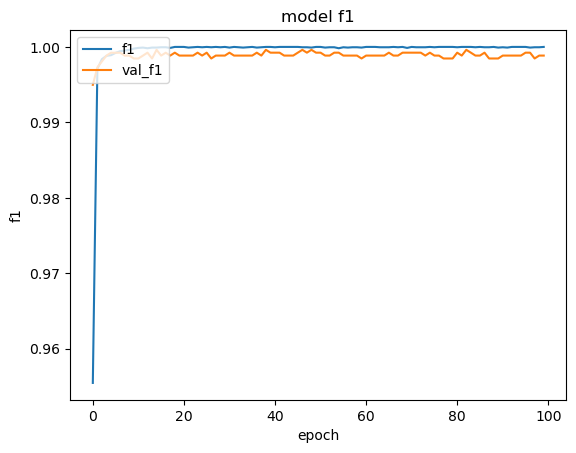

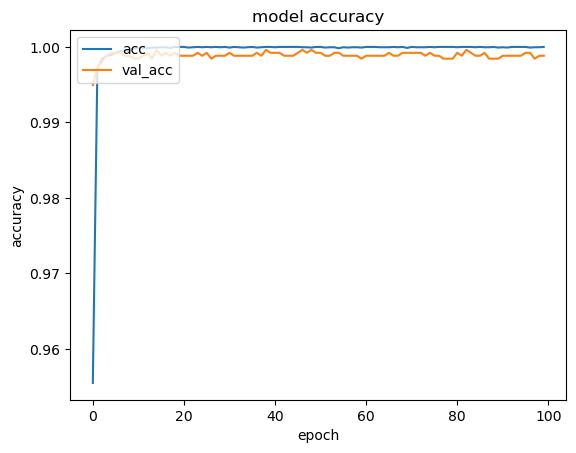

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

plt.plot(history.history['prec'])
plt.plot(history.history['val_prec'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['prec', 'val_prec'], loc='upper left')
plt.show()

plt.plot(history.history['rec'])
plt.plot(history.history['val_rec'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['rec', 'val_rec'], loc='upper left')
plt.show()

plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['f1', 'val_f1'], loc='upper left')
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc'], loc='upper left')
plt.show()

# 4. Model Evaluation

In [23]:
model.evaluate(intent_test_dataset)

201/201 [==============================] - 1s 3ms/step - loss: 0.0047 - acc: 0.9995 - prec: 0.9995 - rec: 0.9995 - f1: 0.9995


[0.004710035398602486,
 0.9995325803756714,
 0.9995325803756714,
 0.9995325803756714,
 0.9995368719100952]

In [24]:
y_true = np.argmax(data_loader.label, axis=-1)
y_pred = np.argmax(model.predict(data_loader.data), axis=-1)
target_names = INTENT_LIST
print(classification_report(y_true, y_pred, target_names=target_names))

151/151 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

      policy       1.00      1.00      1.00      4584
      answer       0.97      1.00      0.99       110
    greeting       1.00      1.00      1.00        30
     confirm       0.97      1.00      0.98        30
    disagree       0.97      1.00      0.98        31
    chitchat       0.96      1.00      0.98        22
      thanks       1.00      1.00      1.00        21

    accuracy                           1.00      4828
   macro avg       0.98      1.00      0.99      4828
weighted avg       1.00      1.00      1.00      4828



# 5. Model Saving and Loading

In [25]:
model.save(f'trained_models/intent_model_{tag}'.format(tag))

In [26]:
name = 'cased_smote_with_faq'
filename = f'trained_models/intent_model_{name}'.format(name)

In [27]:
import shutil
shutil.make_archive('intent_model', 'zip', filename)

'/kaggle/working/intent_model.zip'

In [28]:
%cd /kaggle/working

/kaggle/working


In [29]:
from IPython.display import FileLink 
FileLink(r'intent_model.zip')

/kaggle/working/intent_model.zip

# 6. Model Testing

In [30]:
name = 'cased_smote_with_faq'
filename = f'trained_models/intent_model_{name}'.format(name)

In [31]:
model =  keras.models.load_model(filename)

In [32]:
data_processor = Data_Processor(annotator, tokenizer)

In [33]:
input = 'thạc sĩ á'

In [34]:
tokenized_input = data_processor.data_processing([input])

In [35]:
tokenized_input

{'input_ids': array([[   0, 6603, 6992,    2,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1

In [36]:
embed_data = langauge_model(tokenized_input)[0]
pooling_data = pooling(embed_data)
output = model(pooling_data)[0]
print(output)

tf.Tensor(
[1.3066210e-03 9.9857128e-01 5.9630365e-05 1.7745080e-06 3.1595173e-05
 3.3070232e-06 2.5862004e-05], shape=(7,), dtype=float32)


In [37]:
index = np.argmax(output)

In [38]:
intent = INTENT_LIST[index]

In [39]:
intent

'answer'

In [40]:
index

1